In [50]:
import pandas as pd
import numpy as np
from numpy import vectorize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

import plotly

import plotly.plotly as py
import plotly.graph_objs as go

from ratings.Elo import Elo
from ratings.helpers import log_loss, mlog_loss
from ratings.helpers import squared_error

from ratings.Rate import Rate
from scipy import stats
import timeit

import  plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
#Read in data
fixtures = pd.read_csv('soccer_data_new.csv')
team_info = pd.read_csv('team_info.csv')

In [3]:
#Torneo colors
galaxy_rgb = 'rgb(54,62,79)'
ocean_rgb = 'rgb(14,113,163)'
glacier_rgb = 'rgb(82,194,184)'
orangepop_rgb = 'rgb(241,91,36)'
cloud_rgb = 'rgb(66,186,225)'

galaxy = '#363E4F'
galaxy_light = '#5d6b89'
ocean = '#0e71a3'
ocean_light = '#8ad1f5'
glacier = '#52c2b8'
glacier_light = '#a1ded9'
orangepop = '#f15b24'
orangepop_light = '#f6936f'
cloud = '#42bae1'
cloud_light = '#e9f7fc'

## Home Team Advantage

In [4]:
#localteam_id
#visitorteam_id
fixtures.sort_values('starting_datetime', ascending=False, inplace=True)

In [5]:
local_fixtures = team_info.merge(fixtures, left_on='team_id', right_on='localteam_id', how='inner')
visitor_fixtures = team_info.merge(fixtures, left_on='team_id', right_on='visitorteam_id', how='inner')
all_fixtures = local_fixtures.append(visitor_fixtures, ignore_index=True)

In [6]:
all_fixtures['home_away'] = np.where(all_fixtures['team_id']==all_fixtures['localteam_id'], 'home', 'away')

In [7]:
conditions = [
    ((all_fixtures['home_away'] == 'home') & (all_fixtures['localteam_score'] > all_fixtures['visitorteam_score'])) |\
    ((all_fixtures['home_away'] == 'away') & (all_fixtures['visitorteam_score'] > all_fixtures['localteam_score'])),
    ((all_fixtures['home_away'] == 'home') & (all_fixtures['localteam_score'] < all_fixtures['visitorteam_score'])) |\
    ((all_fixtures['home_away'] == 'away') & (all_fixtures['visitorteam_score'] < all_fixtures['localteam_score'])),
    all_fixtures['localteam_score'] == all_fixtures['visitorteam_score']
]
choices = ['won', 'lost', 'tied']

all_fixtures['outcome'] = np.select(conditions, choices)

In [8]:
all_fixtures['team_score_for'] = np.where(all_fixtures['team_id'] == all_fixtures['localteam_id'], \
                                     all_fixtures['localteam_score'], all_fixtures['visitorteam_score'])
all_fixtures['team_score_against'] = np.where(all_fixtures['team_id'] == all_fixtures['localteam_id'], \
                                     all_fixtures['visitorteam_score'], all_fixtures['localteam_score'])

In [9]:
all_fixtures['team_score_diff'] = all_fixtures['team_score_for'] - all_fixtures['team_score_against']
all_fixtures = all_fixtures.join(pd.get_dummies(all_fixtures['outcome'], prefix='outcome'))
all_fixtures['home_away_bin'] = np.where(all_fixtures['home_away']=='home',1,0)

In [10]:
major_leagues = [8,2, 82, 570, 301,7907,7908,82,564,384,779,648,902, 743,
            636, 968, 462, 486, 989, 208, 600, 609, 573, 591, 1356, 672, 453,
            693, 959, 755, 501, 806, 770]
major_league_fixtures = all_fixtures[all_fixtures['league_id'].isin(major_leagues)]

In [11]:
"""
observed = pl_fixtures[pl_fixtures['home_away_bin']==1]['outcome'].value_counts().sort_values()
expected = pd.Series({'won':1482, 'lost':1482, 'tied':1015}).sort_values()

chi_squared_stat = (((observed-expected)**2)/expected).sum()

print(chi_squared_stat)

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 2)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x = chi_squared_stat,  # Find the p-value
                             df= 2)
print("P value")
print(p_value)

stats.chisquare(f_obs = observed,   # Array of observed counts
                f_exp = expected)   # Array of expected counts
"""

'\nobserved = pl_fixtures[pl_fixtures[\'home_away_bin\']==1][\'outcome\'].value_counts().sort_values()\nexpected = pd.Series({\'won\':1482, \'lost\':1482, \'tied\':1015}).sort_values()\n\nchi_squared_stat = (((observed-expected)**2)/expected).sum()\n\nprint(chi_squared_stat)\n\ncrit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*\n                      df = 2)   # Df = number of variable categories - 1\n\nprint("Critical value")\nprint(crit)\n\np_value = 1 - stats.chi2.cdf(x = chi_squared_stat,  # Find the p-value\n                             df= 2)\nprint("P value")\nprint(p_value)\n\nstats.chisquare(f_obs = observed,   # Array of observed counts\n                f_exp = expected)   # Array of expected counts\n'

In [12]:
import scipy.stats

results = []

for league in major_league_fixtures['league_id'].unique():
    data = major_league_fixtures[major_league_fixtures['league_id'] == league]
    observed_chi2 = pd.crosstab(data['home_away_bin'], data['outcome']).values
    chi2, p, dof, expected = stats.chi2_contingency(observed_chi2)
    results.append(p)

In [13]:
chi2_test = pd.DataFrame(np.column_stack((major_league_fixtures['league_id'].unique(), [round(elem, 5) for elem in results])), \
                         columns=['league_id', 'p_value']) \
                        .set_index('league_id')

In [14]:
chi2_test.join(major_league_fixtures.groupby(['league_id', 'league_name', 'league_country'])['fixture_id']
               .count().reset_index(name='count').set_index('league_id'))

len(chi2_test)

30

### By League

In [1338]:
fixture_counts = major_league_fixtures.groupby('league_id')['fixture_id'].count().reset_index(name='count')
fixture_counts = fixture_counts[fixture_counts['count'] > 200]

In [1361]:
major_fixtures_grped = major_league_fixtures[(major_league_fixtures['home_away'] == 'home') & (major_league_fixtures['league_id'].isin(fixture_counts['league_id']))] \
                        .groupby(['league_id', 'league_name', 'league_country','outcome'])['fixture_id'].count()

In [1362]:
major_fixtures_grped = major_fixtures_grped.fillna(0)

In [1363]:
major_fixtures_grped = pd.DataFrame(major_fixtures_grped) \
                                     .groupby(level=[0,1,2])['fixture_id'] \
                                     .apply(lambda x: x / x.sum()) \
                                     .unstack('outcome')
#major_fixtures_grped['ratio'] = major_fixtures_grped['won'] / major_fixtures_grped['lost']

In [1394]:
major_fixtures_grped['win_loss_ratio'] = major_fixtures_grped['won'] / major_fixtures_grped['lost']

In [1395]:
major_fixtures_grped.sort_values('win_loss_ratio', inplace=True)

In [1396]:
major_fixtures_grped = major_fixtures_grped.reset_index()

In [1514]:
colors = [orangepop_rgb, galaxy_rgb, glacier_rgb]

fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=False,
                          shared_yaxes=False, vertical_spacing=0.001)

data = []
columns = ['won', 'tied', 'lost']
names = ['home win', 'tied', 'away win']

for i, column in enumerate(columns):
    data_new = go.Bar(
        y=major_fixtures_grped['league_name'] + ' (' + major_fixtures_grped['league_country'] + ')  ',
        x=major_fixtures_grped[column].values,
        name=names[i],
        marker=dict(color=colors[i]),
        orientation='h'
    )
    fig.append_trace(data_new, 1, 1)
    
data_new = go.Bar(
    y=major_fixtures_grped['league_name'] + ' (' + major_fixtures_grped['league_country'] + ')  ',
    x=major_fixtures_grped['win_loss_ratio'].values,
    name='home win/ away win ratio',
    marker=dict(color=ocean),
    orientation='h',
    text=round(major_fixtures_grped['win_loss_ratio'],2).values,
    textposition = 'auto',
    textfont=dict(color='#ffffff'),
)
fig.append_trace(data_new, 1, 2)

layout = go.Layout(
    barmode='stack',
    hovermode='closest',
    title='Match Outcomes and Home Win/ Away Win Ratio by League, 2008-2018',
    xaxis=dict(
        tickformat=".0%",
        showgrid=False,
        zeroline=False,
        domain=[0, 0.6]
    ),
    yaxis2=dict(
        visible=False
    ),
    xaxis2=dict(
        showgrid=False,
        zeroline=False,
        domain=[0.6, 1]
    ),
    margin=dict(l=320),
    height=1000,
    font=dict(size=17)
)

fig['layout'].update(layout)
fig['layout']['xaxis1'].update(title='Match Outcomes (% of total)')
fig['layout']['xaxis2'].update(title='Home Win/ Away Win Ratio')
#fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='Home Team Advantage by Season - Premier League')

plot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



'file://C:\\Torneo\\soccer-elo-rating\\temp-plot.html'

### By Seasons

In [1602]:
ten_leagues = [82, 2, 564, 301, 779, 8, 462, 384, 648]
major_league_fixtures['year'] = pd.to_datetime(major_league_fixtures['starting_datetime']).dt.year

In [1603]:
major_league_seasons = major_league_fixtures[(major_league_fixtures['home_away'] == 'home') & (major_league_fixtures['league_id'].isin(ten_leagues))
                                             & (major_league_fixtures['league_id'].isin(fixture_counts['league_id']))] \
                        .groupby(['league_id', 'league_name', 'league_country','year', 'outcome'])['fixture_id'] \
                        .count()

In [1604]:
ml_seasons_grped = pd.DataFrame(major_league_seasons) \
                        .groupby(['league_name', 'league_country', 'year'])['fixture_id'] \
                        .apply(lambda x: x / x.sum()) \
                        .unstack('outcome')

In [1605]:
ml_seasons_grped['win_loss_ratio'] = ml_seasons_grped['won'] / ml_seasons_grped['lost']

In [1606]:
pd.Series(ml_seasons_grped.groupby('league_id')['win_loss_ratio'].mean()).sort_values(ascending=False)

league_id
648.0    2.221724
779.0    2.192668
564.0    1.725097
2.0      1.703442
384.0    1.688920
301.0    1.665542
8.0      1.622611
462.0    1.590135
82.0     1.543055
Name: win_loss_ratio, dtype: float64

In [1607]:
ml_seasons_grped = ml_seasons_grped.reset_index()

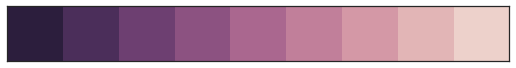

In [1608]:
leagues = ml_seasons_grped['league_id'].unique()

colors = sns.cubehelix_palette(n_colors=len(leagues), reverse=True)
sns.palplot(colors)

team_colors = []

for color in colors:
    values = []
    for value in color:
        value *= 255
        values.append(value)
    values_text = ', '.join(str(x) for x in values)
    values_rgb_str = 'rgb('+ values_text + ')'
    team_colors.append(values_rgb_str)

In [1612]:
team_colors = ['rgb(237.47365169479698, 209.14900580009402, 203.2727648539216)',
 'rgb(237.47365169479698, 209.14900580009402, 203.2727648539216)',
 'rgb(237.47365169479698, 209.14900580009402, 203.2727648539216)',
 'rgb(237.47365169479698, 209.14900580009402, 203.2727648539216)',
 'rgb(44.64707404828123, 30.192059432637937, 61.75077230148308)',
 'rgb(237.47365169479698, 209.14900580009402, 203.2727648539216)',
 'rgb(237.47365169479698, 209.14900580009402, 203.2727648539216)',
 'rgb(237.47365169479698, 209.14900580009402, 203.2727648539216)',
 'rgb(237.47365169479698, 209.14900580009402, 203.2727648539216)']

In [1613]:
data = []

for i, league in enumerate(leagues):
    league_data = ml_seasons_grped[ml_seasons_grped['league_id'] == league]
    league_country = league_data[league_data['league_id'] == league]['league_country'].unique()[0]
    league_name = league_data[league_data['league_id'] == league]['league_name'].unique()[0]
    name =  league_name + ' (' + league_country + ')'
    league_trace = go.Scatter(
        y = league_data['win_loss_ratio'],
        x = league_data['year'],
        line = {'color': team_colors[i]},
        name = name,
        opacity = 0.8)
    data.append(league_trace)
    
layout = dict(
    title='Home Win vs. Away Win Ratio, 2008-2018',
    hovermode = 'closest',
    yaxis = dict(
        showgrid=False
    ),
    font=dict(size=17)
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='Home Team Advantage - Premier League')

plot(fig)

'file://C:\\Torneo\\soccer-elo-rating\\temp-plot.html'

### English Premier League

In [1599]:
pl_fixtures = all_fixtures[all_fixtures['league_id'] == 8]

In [735]:
pl_fixtures_grped = pl_fixtures.groupby(['home_away', 'outcome'])['fixture_id'].count()
pl_fixtures_grped_pct = pl_fixtures_grped.groupby(level=[0]).apply(lambda x: x / x.sum()).unstack('outcome')

In [736]:
pl_fixtures_grped_pct = round(pl_fixtures_grped_pct,4)

In [741]:
pl_fixtures_grped_pct = pl_fixtures_grped_pct[pl_fixtures_grped_pct.columns[[2,1,0]]]

In [1311]:
data = []
colors = [orangepop_rgb, galaxy_rgb, glacier_rgb]

data_new = go.Bar(
    x=pl_fixtures_grped_pct.columns,
    y=pl_fixtures_grped_pct.loc['home'].values,
    text=pl_fixtures_grped_pct.loc['home'].apply(lambda x: '{:.2%}'.format(x)).values,
    textposition = 'auto',
    textfont=dict(color='#ffffff'),
    marker=dict(
        color=colors)
)
data.append(data_new)

layout = go.Layout(
    barmode='stack',
    title='Breakdown of Premier League Match Outcomes for Home Teams, 2008-2018',
    hovermode='closest',
    yaxis=dict(
        tickformat=".2%",
        showgrid=False,
        zeroline=False,
        showticklabels=False
    )
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='Home Team Advantage - Premier League')

offline.iplot({'data': data, 
               'layout': layout},
             image='svg')

### By Season

In [649]:
pl_fixtures_seasons = pl_fixtures.groupby(['season_name','home_away', 'outcome'])['fixture_id'].count()
pl_fixtures_seasons_pct = pl_fixtures_seasons.groupby(level=[0,1]).apply(lambda x: x / x.sum()).unstack('outcome')

In [650]:
seasons_away = pl_fixtures_seasons_pct.xs('away', level='home_away')
seasons_home = pl_fixtures_seasons_pct.xs('home', level='home_away')

In [708]:
seasons_home = seasons_home[seasons_home.columns[[2,1,0]]]

In [1379]:
from plotly import tools

"""
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=False,
                          shared_yaxes=False, vertical_spacing=0.001)
                          
for i, column in enumerate(seasons_away.columns):
    data_new = go.Bar(
        y=seasons_away.index,
        x=seasons_away[column].values,
        name=column,
        orientation='h',
        marker=dict(color=colors[i])
    )
    fig.append_trace(data_new, 1, 2)
    
    xaxis2=dict(
        tickformat=".2%",
        showgrid=False,
        zeroline=False
    )
    
fig['layout'].update(layout)
"""
colors = [orangepop_rgb, galaxy_rgb, glacier_rgb]

data = []

for i, column in enumerate(seasons_home.columns):
    data_new = go.Bar(
        x=seasons_home.index,
        y=seasons_home[column].values,
        name=column,
        marker=dict(color=colors[i])
    )
    data.append(data_new)

layout = go.Layout(
    barmode='stack',
    title='Breakdown of Match Outcomes for Premier League Home Teams by Season',
    hovermode='closest',
    yaxis=dict(
        tickformat=".2%",
        showgrid=False,
        zeroline=False
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Home Team Advantage by Season - Premier League')

### By Teams

In [1621]:
team_counts = pl_fixtures.groupby('team_id')['fixture_id'].count().reset_index(name='count').set_index('team_id')
team_counts = team_counts[team_counts['count'] > 200]

In [1622]:
pl_fixtures_grped_teams = pl_fixtures[pl_fixtures['team_id'].isin(team_counts.index)] \
                            .groupby(['team_id', 'team_name', 'home_away', 'outcome'])['fixture_id'] \
                            .count()
pl_fixtures_grped_teams_pct = pl_fixtures_grped_teams.groupby(level=[0, 1, 2]) \
                                .apply(lambda x: x / x.sum()) \
                                .unstack(['home_away']) \
                                .fillna(0)

In [1623]:
pl_fixtures_grped_teams_pct['home_away_index'] = pd.DataFrame(pl_fixtures_grped_teams_pct.groupby(level=[0]).apply(lambda x: x['home']/x['away'])).values
pl_fixtures_grped_teams_pct = pl_fixtures_grped_teams_pct.unstack(['outcome']).xs('home_away_index', level='home_away', axis=1).reset_index()

In [1624]:
pl_fixtures_grped_teams_pct.set_index('team_id', inplace=True)

In [1625]:
win = pl_fixtures_grped_teams_pct.sort_values('won')
tie = pl_fixtures_grped_teams_pct.sort_values('tied')

In [1631]:
data_win = go.Bar(
    name='Home team effect on wins',
    x=round(win['won'],2).values,
    y=win['team_name'].values,
    orientation='h',
    marker=dict(color=orangepop),
    text=round(win['won'],2).values,
    hoverinfo='y+text'
)

data_win_ref = go.Scatter(
    y=win['team_name'].values,
    x=[1]*len(win.index),
    showlegend=False,
    line=dict(color=glacier, dash='dash'),
    hoverinfo='none'
)

data_tie = go.Bar(
    name='Home team effect on ties',
    x=-round(win['tied'],2).values,
    y=win['team_name'].values,
    orientation='h',
    marker=dict(color=galaxy),
    text=round(win['tied'],2).values,
    hoverinfo="y+text"
)

data_tie_ref = go.Scatter(
    y=win['team_name'].values,
    x=[-1]*len(win.index),
    showlegend=False,
    line=dict(color=glacier, dash='dash'),
    hoverinfo='none'
)

data = [data_win, data_win_ref, data_tie, data_tie_ref]

layout = go.Layout(
    barmode='relative',
    title='Home Field Effect on Wins and Ties - by Premier League Team, 2008 - 2018',
    hovermode='closest',
    margin=dict(l=220),
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        tickmode='array',
        tickvals=[-3, -2, -1, 0, 1, 2, 3, 4],
        ticktext=[3, 2, 1, 0, 1, 2, 3, 4]
    ),
    height=800,
    font=dict(size=17)
)

fig = go.Figure(data=data, layout=layout)
plot(fig)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


'file://C:\\Torneo\\soccer-elo-rating\\temp-plot.html'

## Scores

### Scores for Home vs. Away Games

In [1136]:
sns.set_palette("cubehelix")

In [1137]:
team_name = 'Chelsea'

In [1240]:
#sns.countplot(pl_fixtures[(pl_fixtures['team_name'] == team_name) & (pl_fixtures['home_away'] == 'home')]['team_score_for'])
data_grped_score_for = pl_fixtures.groupby(['home_away','team_score_for'])['team_score_for'].count().reset_index(name='count')
data_grped_score_for['pct_total'] = data_grped_score_for.groupby('home_away')['count'].apply(lambda x: x / x.sum())

In [1634]:
data = []

data_new = go.Bar(
    name='home',
    x=data_grped_score_for[data_grped_score_for['home_away'] == 'home']['team_score_for'].values,
    y=data_grped_score_for[data_grped_score_for['home_away'] == 'home']['pct_total'].values,
    marker=dict(color=orangepop)
)
data.append(data_new)

data_new = go.Bar(
    name='away',
    x=data_grped_score_for[data_grped_score_for['home_away'] == 'away']['team_score_for'].values,
    y=data_grped_score_for[data_grped_score_for['home_away'] == 'away']['pct_total'].values,
    marker=dict(color=glacier)
)
data.append(data_new)

layout = go.Layout(
    barmode='group',
    title='English Premier League Goals, Home vs. Away',
    hovermode='closest',
    yaxis=dict(
        tickformat=".2%",
        showgrid=False,
        zeroline=False
    ),
    font=dict(size=17)
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='Home Team Advantage - Premier League')

plot(fig)

'file://C:\\Torneo\\soccer-elo-rating\\temp-plot.html'

In [1279]:
pl_fixtures_home = pl_fixtures[pl_fixtures['home_away'] == 'home']
attk_def_home = pd.crosstab(pl_fixtures_home['team_score_against'], pl_fixtures_home['team_score_for']).sort_index(ascending=False)

### Score Difference

In [1180]:
#turn into percentages?
sns.set(style="white")
sns.set_palette("viridis")

In [1297]:
data_grped = pl_fixtures.groupby(['home_away','team_score_diff'])['team_score_diff'].count().reset_index(name='count')
data_grped['pct_total'] = data_grped.groupby('home_away')['count'].apply(lambda x: x / x.sum())

In [1636]:
data = []
colors = [orangepop_rgb, galaxy_rgb, glacier_rgb]

data_new = go.Bar(
    name='home',
    x=data_grped[data_grped['home_away'] == 'home']['team_score_diff'].values,
    y=data_grped[data_grped['home_away'] == 'home']['pct_total'].values,
    marker=dict(color=orangepop)
)
data.append(data_new)

data_new = go.Bar(
    name='away',
    x=data_grped[data_grped['home_away'] == 'away']['team_score_diff'].values,
    y=data_grped[data_grped['home_away'] == 'away']['pct_total'].values,
    marker=dict(color=glacier)
)
data.append(data_new)

layout = go.Layout(
    barmode='group',
    title='English Premier League Goal Difference for Home and Away Matches',
    hovermode='closest',
    yaxis=dict(
        tickformat=".2%",
        showgrid=False,
        zeroline=False
    ),
    font=dict(size=17)
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='Home Team Advantage - Premier League')

plot(fig)

'file://C:\\Torneo\\soccer-elo-rating\\temp-plot.html'

## Ratings

In [17]:
rating = Rate()

In [15]:
fixtures_short = fixtures[fixtures['league_id'].isin(major_leagues)]

In [61]:
rating.calculate_elo(fixtures_short, h=100, K=20, Sd=True) 

Prepping data...
Starting calculations...
Calculations completed in 347.051532 seconds=================] 100.0% ... Hooray!


In [64]:
rating.get_log_loss()

(0.45792510006771014, 0.46331538950162621)

In [19]:
fixtures_short = fixtures_short.join(rating.ratings_fixtures)

In [54]:
team_counts = major_league_fixtures.groupby('team_id')['fixture_id'].count().reset_index(name='count').set_index('team_id')
team_counts = team_counts[team_counts['count'] > 100]

In [77]:
ml_fixtures_grped_teams = major_league_fixtures\
                            .groupby(['team_id', 'team_name', 'team_country', 'home_away', 'outcome'])['fixture_id'] \
                            .count()
ml_fixtures_grped_teams_pct = ml_fixtures_grped_teams.groupby(level=[0, 1, 2, 3]) \
                                .apply(lambda x: x / x.sum()) \
                                .unstack(['home_away']) \
                                .fillna(0)
            
ml_fixtures_grped_teams_pct['home_away_index'] = pd.DataFrame(ml_fixtures_grped_teams_pct.groupby(level=[0]).apply(lambda x: x['home']/x['away'])).values
ml_fixtures_grped_teams_pct = ml_fixtures_grped_teams_pct.unstack(['outcome']).xs('home_away_index', level='home_away', axis=1).reset_index()

ml_fixtures_grped_teams_pct.set_index('team_id', inplace=True)

In [81]:
ml_fixtures_grped_teams_pct = ml_fixtures_grped_teams_pct.join(team_counts, how='inner')

In [82]:
team_ratings = rating.ratings_teams
ratings_ratio = ml_fixtures_grped_teams_pct.join(team_ratings.drop('team_name', axis=1))

In [83]:
trace = go.Scatter(
    x = ratings_ratio['rating'],
    y = ratings_ratio['won'],
    mode = 'markers',
    text = ratings_ratio['team_name'] + ' (' + ratings_ratio['team_country'] + '),' + ratings_ratio['count'].astype(str) + ' matches' 
)

layout = go.Layout(
    title='Team Elo Rating vs. Home Win Ratio, 2008-2018',
    hovermode='closest',
    font=dict(size=17)
)

fig = go.Figure(data=[trace], layout=layout)
plot(fig)

'file://C:\\Torneo\\soccer-elo-rating\\temp-plot.html'